In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from utils import plot_images, train_valid_split
from metric import apk, mapk
import lightgbm as lgb

import faiss
import psutil
from lightfm import LightFM
from scipy import sparse
import catboost

In [2]:
dataset = '10'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")
transactions['day'] = (transactions['t_dat'].max() - transactions['t_dat']).dt.days


In [3]:
def lfm(week_start, week_end, target_users):
    NUM_ITEMS = 30
    a = transactions.query("@week_start <= week <= @week_end")
    n_user = len(users)
    n_item = len(items)

    a_train = sparse.lil_matrix((n_user, n_item))
    a_train[a['user'], a['item']] = 1

    no_components = 128
    lightfm_params = {
        'no_components': no_components,
        'learning_schedule': 'adadelta',
        'loss': 'warp',
        'learning_rate': 0.005,
    }

    model = LightFM(**lightfm_params)
    model.fit(a_train, epochs=100, num_threads=psutil.cpu_count(logical=False), verbose=True)
    index = faiss.index_factory(no_components, "Flat", faiss.METRIC_INNER_PRODUCT)
    index = faiss.index_cpu_to_gpu(faiss.StandardGpuResources(), 0, index)
    index.add(model.item_embeddings)
    _, idxs = index.search(model.user_embeddings, NUM_ITEMS)

    return pd.DataFrame({
        'user': np.repeat(target_users, NUM_ITEMS),
        'item': idxs[target_users].flatten(),
        'lfm_rank': list(range(NUM_ITEMS)) * len(target_users),
    })


In [4]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            prefix: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_end: int) -> pd.DataFrame:
        tr = transactions.query(
            "user in @target_users and @week_start <= week <= @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)

        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank()

        candidates = gr_week.merge(gr_volume, on=['user', 'item'])
        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank']].rename(
            columns={'week_rank': f'{prefix}_week_rank', 'volume_rank': f'{prefix}_volume_rank'})
        return candidates

    def create_candidates_popular(
            prefix: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_end: int) -> pd.DataFrame:
        NUM_POPULAR_ITEMS = 18
        tr = transactions.query("@week_start <= week <= @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:NUM_POPULAR_ITEMS]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(NUM_POPULAR_ITEMS),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'{prefix}_rank'})
        return candidates

    def create_candidates_popular_index_group_name(
            prefix: str,
            transactions: pd.DataFrame,
            items: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_end: int,
            index_group_name: str) -> pd.DataFrame:
        NUM_POPULAR_ITEMS = 3
        tr = transactions.query("@week_start <= week <= @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
        tr = tr.merge(items[['item', 'index_group_name']], on='item').query(
            "index_group_name == @index_group_name").drop('index_group_name', axis=1).reset_index(drop=True)

        popular_items = tr['item'].value_counts().index.values[:NUM_POPULAR_ITEMS]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(NUM_POPULAR_ITEMS),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'{prefix}_rank'})
        return candidates

    def create_candidates_cooc(
            prefix: str,
            transactions: pd.DataFrame,
            week_start: int,
            week_end: int,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week == @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query(
            "item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_sz = tr.groupby('item').size().reset_index(name='tot')
        gr_cnt = tr.groupby(['item', 'item_with']).size().reset_index(name='cnt')
        item2item = gr_cnt.merge(gr_sz, on='item')
        item2item['ratio'] = item2item['cnt'] / item2item['tot']
        item2item = item2item.query("ratio >= 0.031043").reset_index(drop=True)

        base_candidates_columns = [c for c in base_candidates.columns if c not in ['user', 'item', 'week']]
        replace = {c: f"{prefix}_{c}" for c in base_candidates_columns}
        candidates = base_candidates.merge(item2item, on='item').drop(
            ['item', 'cnt'], axis=1).rename(columns={'item_with': 'item'}).rename(columns=replace)
        candidates = candidates.rename(columns={'ratio': f'{prefix}_ratio', 'tot': f'{prefix}_tot'})
        return candidates

    def create_candidates_same_product_code(
            prefix: str,
            items: pd.DataFrame,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename(
            {'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        base_candidates_columns = [c for c in base_candidates.columns if c not in ['user', 'item', 'week']]
        replace = {c: f"{prefix}_{c}" for c in base_candidates_columns}
        candidates = base_candidates.merge(
            item2item,
            on='item').drop(
            'item',
            axis=1).rename(
            columns={
                'item_with': 'item'}).rename(
                    columns=replace)
        return candidates

    candidates = [
        create_candidates_repurchase('repurchase', transactions, target_users, week, week + 13),
        create_candidates_popular('pop', transactions, target_users, week, week),

        # create_candidates_popular_index_group_name(
        #     'pop_ladieswear', transactions, items, target_users, week, week, 'Ladieswear'),
        # create_candidates_popular_index_group_name('pop_divided', transactions, items, target_users, week, week, 'Divided'),
        # create_candidates_popular_index_group_name(
        #     'pop_menswear', transactions, items, target_users, week, week, 'Menswear'),
        # create_candidates_popular_index_group_name('pop_sport', transactions, items, target_users, week, week, 'Sport'),
        # create_candidates_popular_index_group_name(
        #     'pop_baby', transactions, items, target_users, week, week, 'Baby/Children'),
    ]
    candidates.append(create_candidates_cooc('cooc', transactions, week, week + 11, candidates[0]))
    candidates.append(create_candidates_same_product_code('same_product_code', items, candidates[0]))
    # candidates.append(lfm(week, week + 3, target_users))

    volumes = np.array([len(c) for c in candidates])
    print(volumes, volumes / np.sum(volumes))

    return pd.concat(candidates).reset_index(drop=True)


In [5]:
# valid: week=1
# train: week=2..1+num_train_weeks
num_train_weeks = 2
candidates = []
for week in range(1, 2+num_train_weeks):
    target_users = transactions[transactions['week'] == week]['user'].unique()
    candidates.append(create_candidates(transactions, target_users, week+1))

[ 59191 123534 263090 334387] [0.07586625 0.15833592 0.33720754 0.42859029]
[ 63120 127548 275197 356587] [0.07674612 0.15508261 0.33460555 0.43356573]
[ 67095 135792 364264 386315] [0.07036958 0.14241934 0.38204194 0.40516914]


In [6]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidates
        (user, item, strategy, score)

    Return
    ------
    (user, item, y, ...)
    """
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)
    remaining_positives = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives / original_positives
    print(f"Recall: {recall}")
    return labels



In [7]:
for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], 1+idx)


Recall: 0.08274075818224629
Recall: 0.08327357475797777
Recall: 0.08007969816439867


In [8]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby(
        'user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


In [9]:
for idx in range(len(candidates)):
    candidates[idx]['week'] = 1+idx

valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 780202 -> 218711
drop trivial queries: 822452 -> 233554
drop trivial queries: 953466 -> 277146


In [10]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    week: これを含めた以前の情報は使って良い
    """
    n_original = len(candidates)
    df = candidates.copy()

    # user static features
    user_features = ['FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx']
    df = df.merge(users[['user'] + user_features], on='user')

    # item static features
    item_features = [c for c in items.columns if c.endswith('idx')]
    df = df.merge(items[['item'] + item_features], on='item')

    # user dynamic features (transactions)
    num_weeks = 8
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='user', how='left')

    # item dynamic features (transactions)
    num_weeks = 8
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item dynamic features (user features)
    num_weeks = 8
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
    tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
    tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item freshness features
    tmp = transactions.query("@week <= week").groupby('item')['week'].min().reset_index(name='item_week_min')
    tmp['item_week_min'] -= week
    df = df.merge(tmp, on='item', how='left')

    # item volume features
    num_weeks = 1
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('item').size().reset_index(name='item_volume')
    df = df.merge(tmp, on='item', how='left')

    # # user freshness features
    # tmp = transactions.query("@week <= week").groupby('user')['week'].min().reset_index(name='user_week_min')
    # tmp['user_week_min'] -= week
    # df = df.merge(tmp, on='user', how='left')

    # # user volume features
    # num_weeks = 1
    # week_end = week + num_weeks
    # tmp = transactions.query("@week <= week < @week_end").groupby('user').size().reset_index(name='user_volume')
    # df = df.merge(tmp, on='user', how='left')

    # user-item freshness features
    tmp = transactions.query("@week <= week").groupby(['user', 'item'])['week'].min().reset_index(name='user_item_week_min')
    tmp['user_item_week_min'] -= week
    df = df.merge(tmp, on=['item', 'user'], how='left')

    # user-item volume features
    num_weeks = 1
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
    df = df.merge(tmp, on=['user', 'item'], how='left')

    assert len(df) == n_original
    return df


valid_all = attach_features(transactions, users, items, valid_all, 2)
for idx in range(len(candidates)):
    candidates[idx] = attach_features(transactions, users, items, candidates[idx], 2+idx)

In [11]:
for idx in range(len(candidates)):
    candidates[idx]['group'] = candidates[idx]['week'].astype(str) + '_' + candidates[idx]['user'].astype(str)
    candidates[idx] = candidates[idx].sort_values(by='group').reset_index(drop=True)

valid = candidates[0]

def concat_train(candidates, begin, num):
    train = pd.concat([candidates[idx] for idx in range(begin, begin+num)])
    return train

train = concat_train(candidates, 1, num_train_weeks)

In [12]:
feature_columns = [c for c in valid.columns if c not in ['y', 'week', 'group']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'cooc_repurchase_week_rank', 'cooc_repurchase_volume_rank', 'cooc_tot', 'cooc_ratio', 'same_product_code_repurchase_week_rank', 'same_product_code_repurchase_volume_rank', 'FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_week_min', 'item_volume', 'user_item_week_min', 'user_item_volume']


In [13]:
cat_feature_values = [c for c in feature_columns if c.endswith('idx')]
cat_features = [feature_columns.index(c) for c in cat_feature_values]
cat_features


[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]

In [14]:
train_pool = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['group'], cat_features=cat_features)
valid_pool = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['group'], cat_features=cat_features)

In [15]:
params = {
    'loss_function': 'YetiRank',
    'use_best_model': True,
    'one_hot_max_size': 300,
}
model = catboost.CatBoost(params)
model.fit(train_pool, eval_set=valid_pool)

0:	test: 0.2122441	best: 0.2122441 (0)	total: 297ms	remaining: 9m 54s
1:	test: 0.2711024	best: 0.2711024 (1)	total: 504ms	remaining: 8m 23s
2:	test: 0.2779011	best: 0.2779011 (2)	total: 702ms	remaining: 7m 47s
3:	test: 0.2795923	best: 0.2795923 (3)	total: 903ms	remaining: 7m 30s
4:	test: 0.2819510	best: 0.2819510 (4)	total: 1.09s	remaining: 7m 17s
5:	test: 0.3138884	best: 0.3138884 (5)	total: 1.3s	remaining: 7m 12s
6:	test: 0.3164567	best: 0.3164567 (6)	total: 1.51s	remaining: 7m 10s
7:	test: 0.3239150	best: 0.3239150 (7)	total: 1.72s	remaining: 7m 7s
8:	test: 0.3295655	best: 0.3295655 (8)	total: 1.92s	remaining: 7m 4s
9:	test: 0.3363650	best: 0.3363650 (9)	total: 2.12s	remaining: 7m 1s
10:	test: 0.3379181	best: 0.3379181 (10)	total: 2.32s	remaining: 6m 59s
11:	test: 0.3486417	best: 0.3486417 (11)	total: 2.52s	remaining: 6m 57s
12:	test: 0.3515895	best: 0.3515895 (12)	total: 2.73s	remaining: 6m 57s
13:	test: 0.3537108	best: 0.3537108 (13)	total: 2.94s	remaining: 6m 57s
14:	test: 0.3578

In [16]:
# recent_items = transactions.query("2 <= week <= 4").item.unique()
# valid_all = valid_all.query("item in @recent_items")


In [17]:
valid_all['pred'] = model.predict(valid_all[feature_columns])
pred = valid_all.groupby(['user', 'item'])['pred'].max().reset_index()


In [18]:
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(
    drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
pred


,user,item
0,7,"[71850, 55259, 71853, 45075, 57707, 84694, 247..."
1,17,"[45075, 57707, 2474, 54591, 32619, 78443, 8448..."
2,46,"[54591, 45075, 57707, 2474, 32619, 85168, 8525..."
3,76,"[11405, 33620, 11419, 11406, 11427, 11426, 425..."
4,93,"[71324, 85251, 83189, 45075, 2474, 67794, 8499..."
...,...,...
6858,137130,"[57707, 78443, 54591, 78014, 32619, 84483, 851..."
6859,137154,"[82865, 84995, 84993, 82866, 75565, 84994, 755..."
6860,137163,"[33118, 33134, 83189, 78443, 74476, 57707, 545..."
6861,137193,"[79762, 79760, 48729, 79763, 83785, 79761, 837..."


In [19]:
gt = transactions[transactions['week'] == 1].groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)
merged


,user,gt,item
0,7,[84694],"[71850, 55259, 71853, 45075, 57707, 84694, 247..."
1,17,"[36829, 78443]","[45075, 57707, 2474, 54591, 32619, 78443, 8448..."
2,46,"[54978, 74827, 64682, 84694]","[54591, 45075, 57707, 2474, 32619, 85168, 8525..."
3,76,[78876],"[11405, 33620, 11419, 11406, 11427, 11426, 425..."
4,93,"[67140, 65]","[71324, 85251, 83189, 45075, 2474, 67794, 8499..."
...,...,...,...
6858,137130,"[76898, 76898]","[57707, 78443, 54591, 78014, 32619, 84483, 851..."
6859,137154,"[79765, 80293]","[82865, 84995, 84993, 82866, 75565, 84994, 755..."
6860,137163,"[77982, 85608, 60208]","[33118, 33134, 83189, 78443, 74476, 57707, 545..."
6861,137193,"[85512, 85512, 85513, 85513, 82631, 85878]","[79762, 79760, 48729, 79763, 83785, 79761, 837..."


In [20]:
mapk(merged['gt'], merged['item'])


0.02743826806953757

In [21]:
popular_items = transactions[transactions['week'] == 2]['item'].value_counts()[:12].index.tolist()
merged['item'] = merged['item'].apply(lambda x: x + popular_items)
mapk(merged['gt'], merged['item'])


0.02743826806953757

In [22]:
# assert False

submission

In [23]:
train = concat_train(candidates, 0, num_train_weeks)

In [24]:
train_pool = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['group'], cat_features=cat_features)

params = {
    'iterations': model.get_best_iteration(),
    'loss_function': 'YetiRank',
    'one_hot_max_size': 300,
}
model = catboost.CatBoost(params)
model.fit(train_pool)

0:	total: 159ms	remaining: 2m 33s
1:	total: 304ms	remaining: 2m 27s
2:	total: 452ms	remaining: 2m 25s
3:	total: 602ms	remaining: 2m 25s
4:	total: 745ms	remaining: 2m 23s
5:	total: 893ms	remaining: 2m 23s
6:	total: 1.04s	remaining: 2m 23s
7:	total: 1.19s	remaining: 2m 22s
8:	total: 1.34s	remaining: 2m 23s
9:	total: 1.49s	remaining: 2m 22s
10:	total: 1.64s	remaining: 2m 22s
11:	total: 1.78s	remaining: 2m 22s
12:	total: 1.93s	remaining: 2m 22s
13:	total: 2.07s	remaining: 2m 21s
14:	total: 2.21s	remaining: 2m 20s
15:	total: 2.35s	remaining: 2m 20s
16:	total: 2.5s	remaining: 2m 20s
17:	total: 2.65s	remaining: 2m 20s
18:	total: 2.8s	remaining: 2m 20s
19:	total: 2.96s	remaining: 2m 20s
20:	total: 3.11s	remaining: 2m 20s
21:	total: 3.26s	remaining: 2m 20s
22:	total: 3.42s	remaining: 2m 20s
23:	total: 3.57s	remaining: 2m 20s
24:	total: 3.73s	remaining: 2m 20s
25:	total: 3.88s	remaining: 2m 20s
26:	total: 4.02s	remaining: 2m 20s
27:	total: 4.17s	remaining: 2m 20s
28:	total: 4.34s	remaining: 2m 2

KeyboardInterrupt: 

In [ ]:
target_users = users['user'].values
target_users

array([      0,       1,       2, ..., 1371977, 1371978, 1371979])

In [ ]:
candidates = create_candidates(transactions, target_users, 1)

[  922148 32927520  3362926  6069600] [0.02130548 0.76076365 0.07769768 0.14023319]


In [ ]:
candidates = attach_features(transactions, users, items, candidates, 1)

In [ ]:
candidates['pred'] = model.predict(candidates[feature_columns])
pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index()

In [ ]:
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(
    drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
pred


,user,item
0,0,"[16023, 16024, 16003, 16004, 16013, 16017, 104..."
1,1,"[95499, 3091, 104045, 104553, 104072, 103796, ..."
2,2,"[78503, 78505, 104072, 104553, 103797, 104527,..."
3,3,"[67522, 104553, 103796, 104874, 104072, 71107,..."
4,4,"[104553, 103796, 104527, 104874, 104072, 10455..."
...,...,...
1371975,1371975,"[77908, 81224, 77915, 81226, 13338, 81232, 104..."
1371976,1371976,"[104072, 104553, 95499, 103797, 104045, 103796..."
1371977,1371977,"[71106, 71101, 71107, 71110, 71109, 71103, 104..."
1371978,1371978,"[56694, 3091, 95499, 104072, 104045, 103797, 1..."


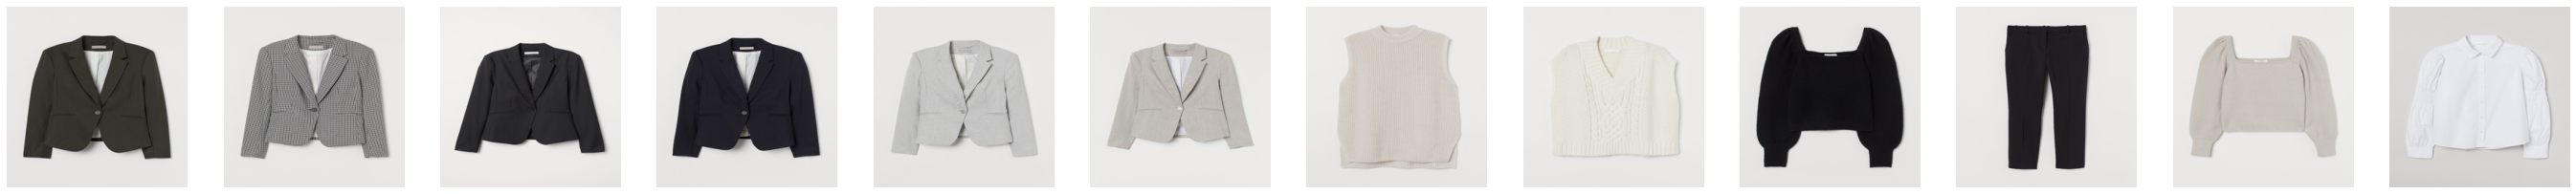

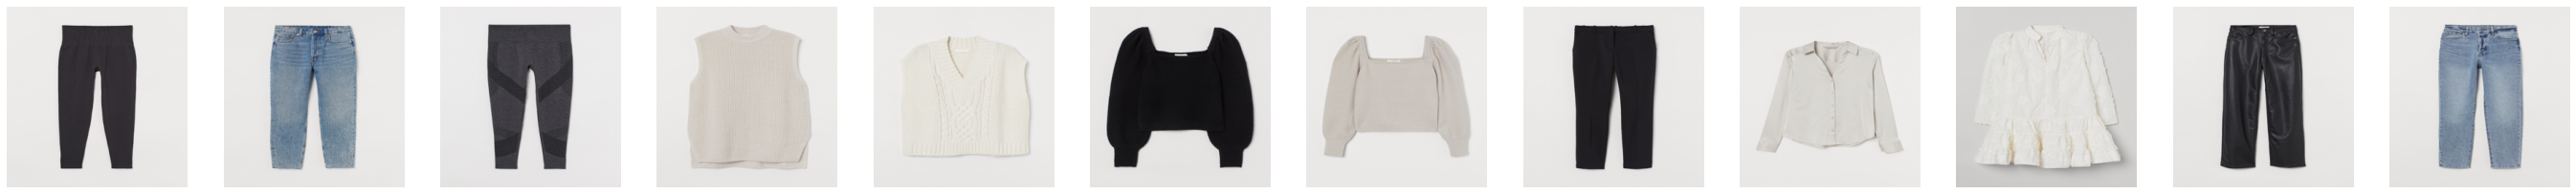

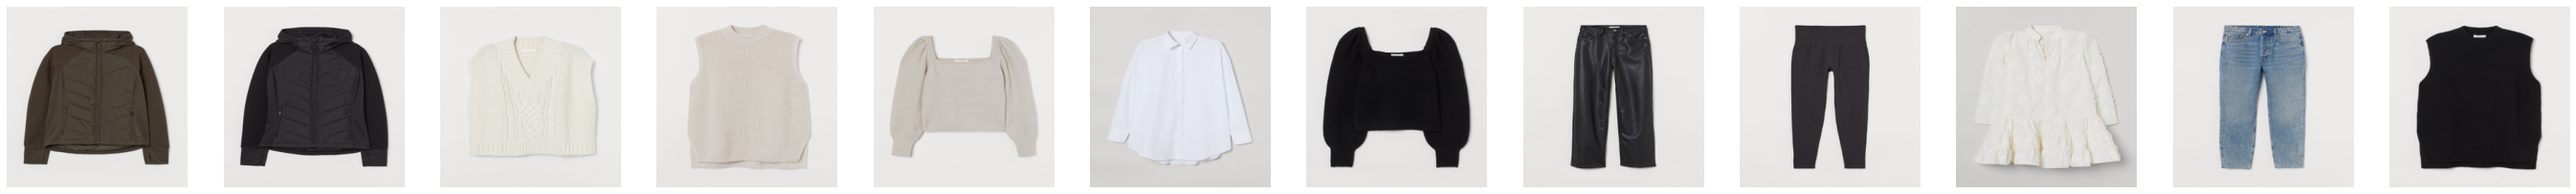

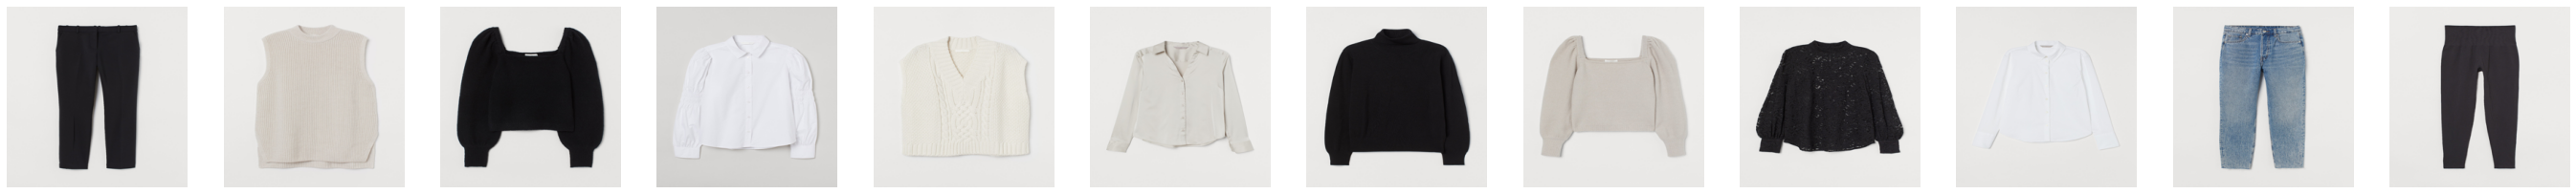

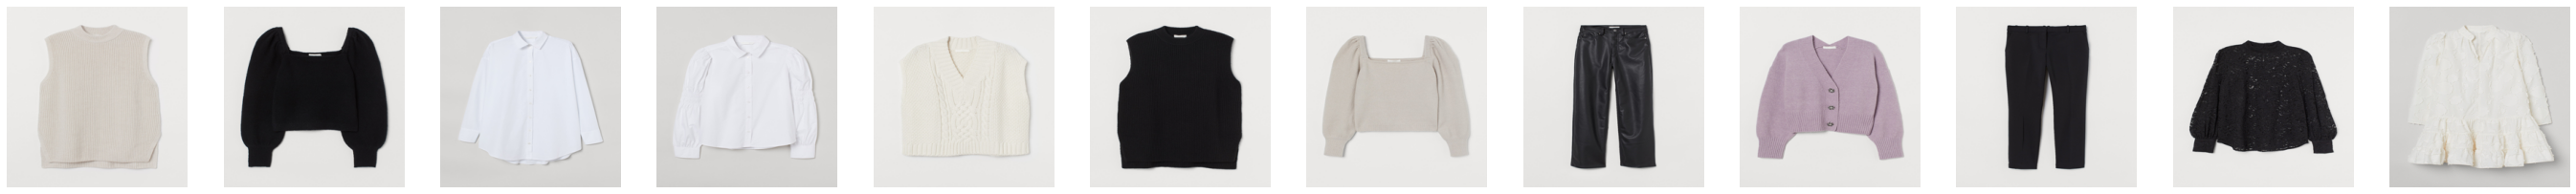

In [ ]:
for i in range(5):
    plot_images(dataset, pred['item'][i])

In [ ]:
mp_user = pd.read_pickle(f"input/{dataset}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"input/{dataset}/mp_article_id.pkl")

In [ ]:
a_user = mp_user['val'].values
a_item = mp_item['val'].values

In [ ]:
pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))

In [ ]:
pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x)))

In [ ]:
submission = pred[['customer_id', 'prediction']]
submission

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0568601044 0568601006 0568601007 05...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0866731001 0448509014 0918292001 0924243001 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0794321011 0918522001 0924243001 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0751471001 0924243001 0915529003 0928206001 09...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0924243001 0915529003 0923758001 0928206001 09...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0791587001 0804992014 0791587015 0804992017 05...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0918522001 0924243001 0866731001 0915529005 09...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0762846026 0762846006 0762846027 0762846031 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0714790020 0448509014 0866731001 0918522001 09...


In [ ]:
submission.to_csv('submission.csv', index=False)